In [7]:
import ee
import rasterio
import numpy as np
from pprint import pprint
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import colors

In [3]:
from channel_classifier.internal.ee_utils import add_labels, add_cloud_score, add_cloud_label, compute_error_image, get_landsat_image, get_landsat_images, get_landsat_composite, remap_modis_labels
from channel_classifier.internal.utils import read_image_list, download_tiff
from channel_classifier.internal.settings import TRAINING_BANDS, MODIS_KEEP_VALUES, JRC_VALUES

In [4]:
from skimage.morphology import binary_dilation, binary_erosion, disk

In [5]:
CLOUD_THRESH = 20.0
MODIS_LABELS = ['']

In [6]:
datasets = {'LE7' : 'LANDSAT/LE07/C01/T1_TOA',
            'LT5' : 'LANDSAT/LT05/C01/T1_TOA',
           }

In [6]:
modis_proj = ee.Image('MODIS/006/MCD12Q1/2012_01_01').projection().getInfo()
water_proj = ee.Image('JRC/GSW1_0/MonthlyHistory/2012_01').projection().getInfo()
landsat_img = ee.Image(ee.ImageCollection('LANDSAT/LE07/C01/T1_TOA').first())
print(modis_proj['crs'])
print(modis_proj['transform'])
print(water_proj['crs'])
print(water_proj['transform'])

SR-ORG:6974
[463.312716528, 0.0, -20015109.354, 0.0, -463.312716527, 10007554.677]
EPSG:4326
[0.00026949458523585647, 0.0, -180.00001488697754, 0.0, -0.00026949458523585647, 78.00008729939917]


In [137]:
ee.Initialize()

In [143]:
le7 = 'LANDSAT/LE07/C01/T1_TOA'
path, row = [7, 65] # Ucayali
#path, row = [74, 16] # Alaska
#path, row = [3, 69] # RMDD
year, month, day = [2001, 4, 4]
image = get_landsat_image(path, row, year, month, day, dataset_path=le7)
TRAINING_BANDS = image.bandNames().getInfo()
TRAINING_BANDS.remove('BQA')
image = add_cloud_score(image)
stacked = add_labels(image)
labels = remap_modis_labels(stacked)
bands = stacked.bandNames().getInfo()
bands.remove('label')
print(bands)
stacked = stacked.select(bands)
print(stacked.bandNames().getInfo())
stacked = stacked.addBands(labels, ['label'])
stacked = add_cloud_label(stacked, 50)
#stacked = stacked.select(TRAINING_BANDS)
#stacked = mask_channels(stacked)
proj = stacked.select(['B1']).projection()
scale = stacked.select(['B1']).projection().nominalScale()
print(stacked.bandNames().getInfo())

[u'B1', u'B2', u'B3', u'B4', u'B5', u'B6_VCID_1', u'B6_VCID_2', u'B7', u'B8', u'BQA', u'cloud']
[u'B1', u'B2', u'B3', u'B4', u'B5', u'B6_VCID_1', u'B6_VCID_2', u'B7', u'B8', u'BQA', u'cloud']
[u'B1', u'B2', u'B3', u'B4', u'B5', u'B6_VCID_1', u'B6_VCID_2', u'B7', u'B8', u'BQA', u'cloud', u'label']


[u'B1', u'B2', u'B3', u'B4', u'B5', u'B6_VCID_1', u'B6_VCID_2', u'B7', u'B8', u'BQA', u'cloud']


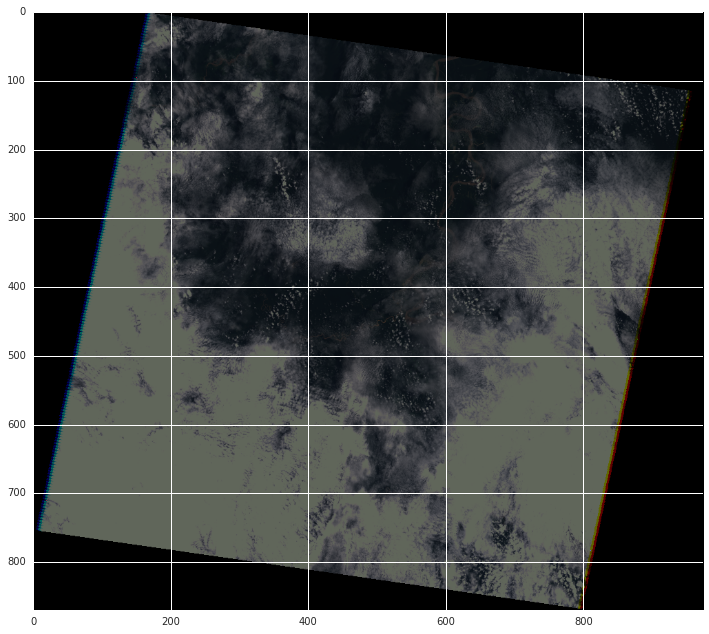

In [144]:
print(image.bandNames().getInfo())
filename = download_tiff(image.clip(image.geometry()), scale=240)
with rasterio.open(filename) as r:
    im = r.read()
rgb = np.stack([im[2], im[1], im[0]], axis=-1)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(rgb)

(1.0, 8.0)


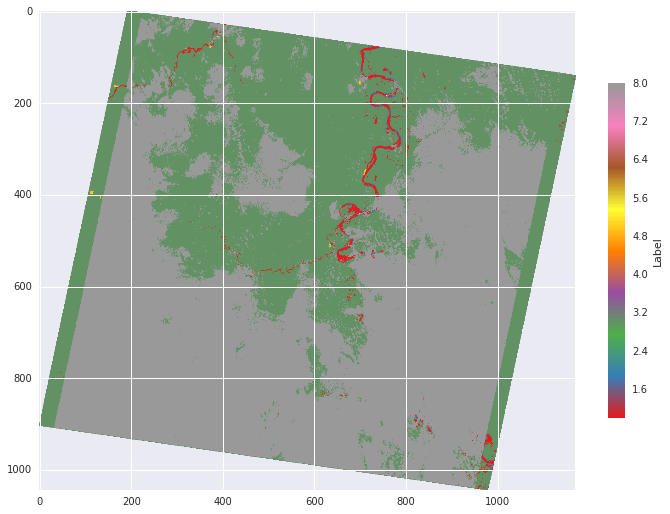

In [145]:
filename = download_tiff(stacked.clip(image.geometry()), scale=200)
with rasterio.open(filename) as r:
    labels = r.read(r.count).astype(float)
    #labels[labels == 12] = 2
    labels[labels == 0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(labels, cmap='Set1', vmin=1, vmax=8)
plt.colorbar(im, ax=ax, label='Label', shrink=0.5)
print(np.nanmin(labels), np.nanmax(labels))

In [26]:
training = stacked.sample(numPixels=10000, projection=proj, scale=1, seed=0).filter(ee.Filter.neq('label', 0))
validation = stacked.sample(numPixels=10000, projection=proj, scale=1, seed=1).filter(ee.Filter.neq('label', 0))

In [27]:
clf = ee.Classifier.randomForest(10)
print(clf.mode().getInfo())
#clf = clf.setOutputMode('PROBABILITY')
print(clf.mode().getInfo())
classifier = clf.train(training, 'label')

CLASSIFICATION
CLASSIFICATION


In [28]:
classified = stacked.classify(classifier, 'classification')
print(classified.bandNames().getInfo())

[u'classification']


In [29]:
validated = validation.classify(classifier, 'classification')
accuracy = validated.errorMatrix('label', 'classification')
print(accuracy.accuracy().getInfo()

0.993353958978


In [46]:
error = compute_error_image(stacked.select(['label']), classified.clip(image.geometry()), 1)

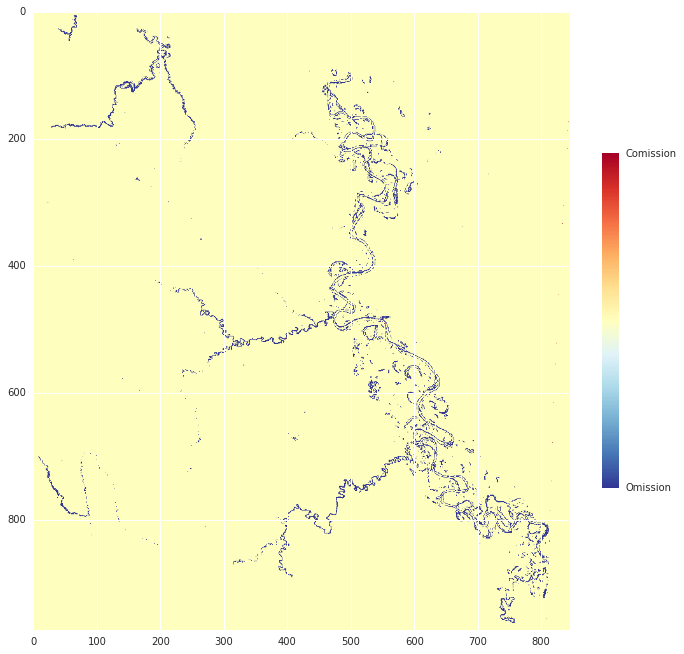

In [47]:
filename = download_tiff(error, scale=240)
with rasterio.open(filename) as r:
    err = r.read(1)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(err, cmap='RdYlBu_r', vmin=-1, vmax=1) #, cmap=cmap, norm=norm)
cb = plt.colorbar(im, ax=ax, shrink=0.5, ticks=[-1, 0, 1])
cb.ax.set_yticklabels(['Omission', '', 'Comission']);

In [42]:
error = compute_error_image(stacked.select(['label']), classified.clip(image.geometry()), 2)

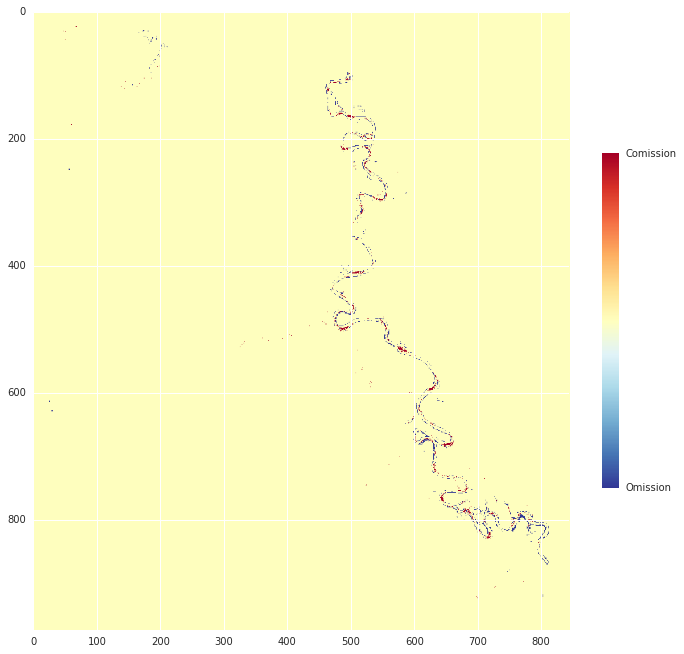

In [44]:
filename = download_tiff(error, scale=240)
with rasterio.open(filename) as r:
    err = r.read(1)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(err, cmap='RdYlBu_r', vmin=-1, vmax=1) #, cmap=cmap, norm=norm)
cb = plt.colorbar(im, ax=ax, shrink=0.5, ticks=[-1, 0, 1])
cb.ax.set_yticklabels(['Omission', '', 'Comission']);

In [32]:
filename = download_tiff(classified.select(['classification']), scale=200)

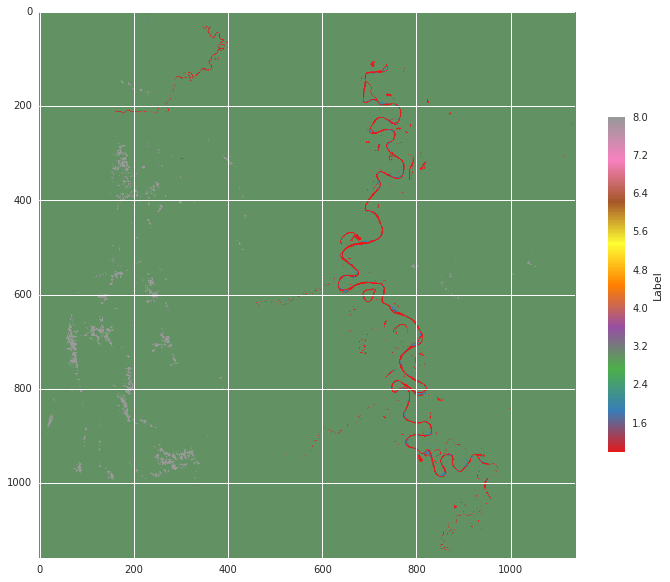

In [34]:
filename = download_tiff(classified.select(['classification']).clip(image.geometry()), scale=200)
with rasterio.open(filename) as r:
    labels = r.read(1).astype(float)
    #labels[labels == 12] = 2
    #labels[labels == 0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(labels, cmap='Set1', vmin=1, vmax=8)
plt.colorbar(im, ax=ax, label='Label', shrink=0.5)

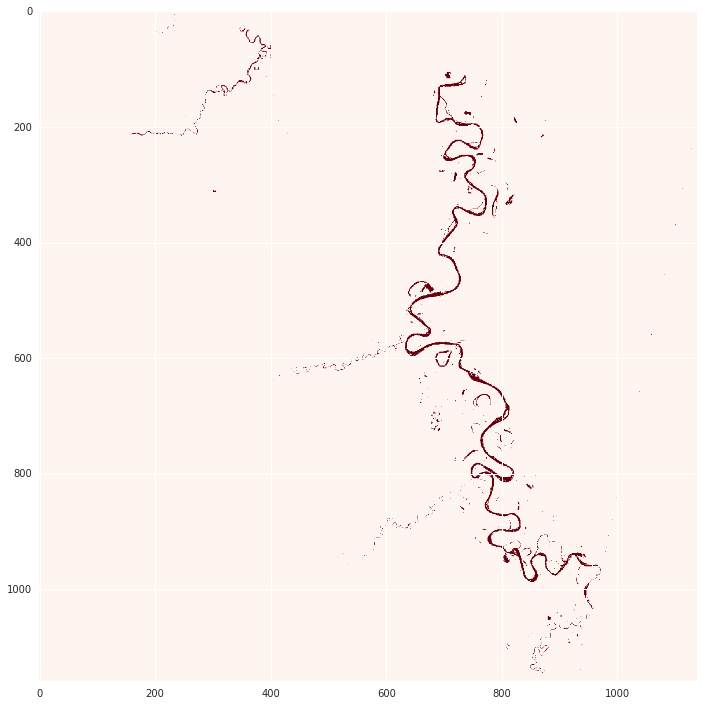

In [36]:
good = (labels == 1) | (labels == 2)
fig, ax = plt.subplots(1, 1, figsize=(12,12))
im = ax.imshow(good, cmap='Reds', vmin=0, vmax=1)

In [37]:
filename = download_tiff(stacked.select(['label']), scale=200)
with rasterio.open(filename) as r:
    labels = r.read(1).astype(float)
values = np.unique(labels)

In [41]:
print('class\taccuracy')
for val in values:
    validation = stacked.sample(numPixels=10000, projection=proj, scale=1, seed=1).filter(ee.Filter.eq('label', val))
    validated = validation.classify(classifier, 'classification')
    accuracy = validated.errorMatrix('label', 'classification')
    acc = accuracy.accuracy().getInfo()
    print('{:.0f}\t{:.2f}'.format(val, acc))

class	accuracy
0	0.00
1	0.93
2	0.04
3	1.00
4	0.00
5	0.00
8	1.00


In [55]:
print(image.getInfo()['bands'][0]['dimensions'])

[7601, 7731]


In [80]:
import tempfile, urllib, zipfile
def download_tiff_native(image):
    proj = image.select(['B2']).projection().getInfo()
    crs = proj['crs']
    crs_transform = proj['transform']
    dims = image.getInfo()['bands'][0]['dimensions']
    url = ee.data.makeDownloadUrl(ee.data.getDownloadId({
        'image': image.serialize(),
        'crs' : crs,
        'scale' : 30,
        'filePerBand': 'false',
        'name': 'data',
    }))
    local_zip, headers = urllib.urlretrieve(url)
    with zipfile.ZipFile(local_zip) as local_zipfile:
        return local_zipfile.extract('data.tif', tempfile.mkdtemp())

In [94]:
def download_rgb_tiff(image):
    filename = download_tiff_native(stacked.select(['B2', 'B3', 'B4', 'label']))
    path = image.get('WRS_PATH').getInfo()
    row = image.get('WRS_ROW').getInfo()
    year = image.date().get('year').getInfo()
    month = image.date().get('month').getInfo()
    day = image.date().get('day').getInfo()
    out_filename = 'L8_{}_{}_{}_{}_{}.tif'.format(path, row, year, month, day)

    with rasterio.open(filename) as r:
        # XXX: Assumes Landsat 8 for now
        red = rescale_band_to_byte(r.read(3))
        green = rescale_band_to_byte(r.read(2))
        blue = rescale_band_to_byte(r.read(1))
        label = r.read(r.count)
        profile = r.profile
        profile.update(count=4, dtype=rasterio.uint8)

    with rasterio.open(out_filename, 'w', **profile) as out:
        dtype = profile['dtype']
        out.write(red.astype(dtype), 1)
        out.write(green.astype(dtype), 2)
        out.write(blue.astype(dtype), 3)
        out.write(label.astype(dtype), 4)
        
    return out_filename

In [85]:
def save_binary_mask(classified, out_filename, keep_labels):
    in_filename = download_tiff_native(classified)
    with rasterio.open(in_filename) as r:
        labels = r.read(1)
        profile = r.profile
        profile.update(count=1, dtype=rasterio.uint8)

    mask = np.isin(labels, keep_labels)
    labels[mask] = 1
    labels[~mask] = 0
    with rasterio.open(out_filename, 'w', **profile) as out:
        out.write(labels.astype(rasterio.uint8), 1)

In [146]:
download_rgb_tiff(image)

'L8_7_65_2001_4_4.tif'

In [69]:
save_binary_mask(classified.select(['classification']), 'C_LC8_{}_{}_{}{}{}.tif'.format(path, row, year, month, day), keep_labels=[1, 2])

/usr/local/lib/python2.7/dist-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [97]:
def download_rgb_images(images):
    filenames = []
    for image in images:
        fn = download_rgb_image(image)
        filenames.append(fn)
    return filenames

In [109]:
def add_cloud_label(image, thresh=50):
    """
    Adds a cloud label based on cloud score threshold.
    The largest resulting label value corresponds to the 'cloud' class.
    """

    bands = image.bandNames().getInfo()

    if 'cloud' in bands:
        mask = image.select(['cloud']).gt(ee.Number(thresh))
    else:
        raise Exception('Image does not have a cloud score band; use add_cloud_score first')

    if 'label' in bands:
        label = image.select(['label'])
        cloud_value = ee.Number(8)
        label = label.where(mask, ee.Image.constant(cloud_value))
        image = image.addBands(label, ['label'], overwrite=True)
    else:
        raise Exception('Image does not have a label band; use add_labels first')
    
    return image

In [134]:
def add_labels(image):
    year = image.date().get('year').getInfo()
    month = image.date().get('month').getInfo()

    proj = image.projection()
    
    modis_year = min(year, 2016)
    timestamp = '{}_01_01'.format(modis_year)
    modis = ee.Image('MODIS/006/MCD12Q1/{}'.format(timestamp)).select('LC_Type1')#.reproject(proj)
    
    label_values = np.arange(0, 18)
    discard_values = list(set(label_values) - set(MODIS_KEEP_VALUES))
    for value in discard_values:
        modis = modis.multiply(modis.neq(ee.Number(value)))
        
    modis = modis.add(ee.Number(1))
    modis = modis.multiply(modis.neq(ee.Number(1))) # Remove water labels
    stacked = modis.clip(image.geometry())
    
    jrc_year = min(year, 2015)
    timestamp = '{:d}_{:02d}'.format(jrc_year, month)
    water = ee.Image('JRC/GSW1_0/MonthlyHistory/{}'.format(timestamp))#.reproject(proj)
    for k in JRC_VALUES:
        mask = water.neq(ee.Number(k))
        stacked = stacked.multiply(mask)
        stacked = stacked.add(water.eq(ee.Number(k)))

    new_bands = stacked.bandNames().getInfo()
    new_bands.remove('LC_Type1')
    new_bands.append('label')
    stacked = stacked.rename(new_bands).clip(image.geometry())

    return image.addBands(stacked, new_bands, overwrite=True)

In [129]:
def identity(image):
    return image

In [135]:
def save_labelled_images(path, row, start_date, end_date):
    images = get_landsat_images(path, row, start_date, end_date)
    print(images.size().getInfo())
    images = images.map(add_labels) #\
            #.map(remap_modis_labels) \
            #.map(add_cloud_label)
    #filenames = download_rgb_images(images)
    #return filenames

In [136]:
filenames = save_labelled_images(path, row, '2013-01-01', '2014-01-01')

10


EEException: Failed to decode JSON.
Error: Field 'value' of object '{"type":"ArgumentRef","value":null}' is missing or null.
Object: {"type":"ArgumentRef","value":null}.